# Import essential libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer
import pyLDAvis.sklearn
from statsmodels.tsa.stattools import grangercausalitytests

/home/saras/anaconda3/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


In [2]:
import numpy as np
from sklearn.utils import check_random_state
from sklearn.decomposition._online_lda_fast import _dirichlet_expectation_2d
class PTW_LDA(LatentDirichletAllocation):

    def __init__(self, n_components=10, *, doc_topic_prior=None,
                 topic_word_prior=None, learning_method='batch',
                 learning_decay=.7, learning_offset=10., max_iter=10,
                 batch_size=128, evaluate_every=-1, total_samples=1e6,
                 perp_tol=1e-1, mean_change_tol=1e-3, max_doc_update_iter=100,
                 n_jobs=None, verbose=0, random_state=None, 
                 ptws=None):
        super(PTW_LDA, self).__init__(n_components, doc_topic_prior, topic_word_prior, 
                                      learning_method, learning_decay, learning_offset, 
                                      max_iter, batch_size, evaluate_every, total_samples, 
                                      perp_tol, mean_change_tol, max_doc_update_iter, 
                                      n_jobs, verbose, random_state)
        self.ptws = ptws

    def _init_latent_vars(self, n_features):
        """Initialize latent variables."""

        self.random_state_ = check_random_state(self.random_state)
        self.n_batch_iter_ = 1
        self.n_iter_ = 0

        if self.doc_topic_prior is None:
            self.doc_topic_prior_ = 1. / self.n_components
        else:
            self.doc_topic_prior_ = self.doc_topic_prior

        if self.topic_word_prior is None:
            self.topic_word_prior_ = 1. / self.n_components
        else:
            self.topic_word_prior_ = self.topic_word_prior

        init_gamma = 100.
        init_var = 1. / init_gamma
        # In the literature, this is called `lambda`
        self.components_ = self.random_state_.gamma(
            init_gamma, init_var, (self.n_components, n_features))

        # Transform topic values in matrix for prior topic words
        if self.ptws is not None:
            for ptw in self.ptws:
                word_index = ptw[0]
                word_topic_values = ptw[1]
                self.components_[:, word_index] *= word_topic_values

        # In the literature, this is `exp(E[log(beta)])`
        self.exp_dirichlet_component_ = np.exp(
            _dirichlet_expectation_2d(self.components_))

/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def lemma_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Merge NYT data
main_df = pd.read_csv('NYT2000_1.csv', usecols=['Body', 'Publication Day Of Month', 'Publication Month', 'Publication Year'])
temp_df = pd.read_csv('NYT2000_2.csv', usecols=['Body', 'Publication Day Of Month', 'Publication Month', 'Publication Year'])
main_df = pd.concat([main_df,temp_df], ignore_index=True)

/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Remove NaN values, lowercase contents of Body column, filters for bush and gore and resets the index
main_df.dropna(subset=['Body'], inplace=True)
main_df['Body'] = main_df['Body'].str.lower()
main_df = main_df[main_df['Body'].str.contains('gore|bush')]
main_df = main_df.reset_index(drop=True)

print(main_df.shape)
print(main_df['Body'].head(10))

/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4706, 4)
0    just before the july 4 recess, a senate commit...
1    george w. bush -- pittsburgh and east brunswic...
2    drivers have been paying almost twice as much ...
3    for farmers, the months leading to harvest tim...
4    international a3-13 u.s. and vietnam reach bro...
5    dna test fails to exonerate prisoner given sta...
6    former senator bill bradley made it official t...
7    from his opening salutation ''i am a member of...
8    the democratic national committee's new televi...
9    several homeowners, cell phones at hand, tend ...
Name: Body, dtype: object


In [6]:
# Create a single date column from day, month and year columns
main_df['Date'] = pd.to_datetime(
    main_df['Publication Year'] * 10000 + main_df['Publication Month'] * 100 + main_df['Publication Day Of Month'],
    format='%Y%m%d')
main_df.drop(['Publication Year', 'Publication Month', 'Publication Day Of Month'], axis=1, inplace=True)

print(main_df.head(10))

                                                Body       Date
0  just before the july 4 recess, a senate commit... 2000-07-13
1  george w. bush -- pittsburgh and east brunswic... 2000-07-13
2  drivers have been paying almost twice as much ... 2000-07-13
3  for farmers, the months leading to harvest tim... 2000-07-13
4  international a3-13 u.s. and vietnam reach bro... 2000-07-13
5  dna test fails to exonerate prisoner given sta... 2000-07-13
6  former senator bill bradley made it official t... 2000-07-13
7  from his opening salutation ''i am a member of... 2000-07-13
8  the democratic national committee's new televi... 2000-07-13
9  several homeowners, cell phones at hand, tend ... 2000-07-13


/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# Remove unnecessary symbols, numbers, words less than 3 characters and apply lemmatizer
main_df['Body'].replace([r'[,\.!?]', r'\d+', r'\b(\w{1,2})\b'], '', inplace=True, regex=True)
main_df['Body'].apply(lemma_text)
main_df['Body'] = main_df['Body'].str.replace('said', '', regex=False)

print(main_df.head(10))

/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                                Body       Date
0  just before the july  recess  senate committee... 2000-07-13
1  george  bush -- pittsburgh and east brunswick ... 2000-07-13
2  drivers have been paying almost twice  much fo... 2000-07-13
3  for farmers the months leading  harvest time a... 2000-07-13
4  international -  and vietnam reach broad trade... 2000-07-13
5  dna test fails  exonerate prisoner given stay ... 2000-07-13
6  former senator bill bradley made  official tod... 2000-07-13
7  from his opening salutation ''   member  the n... 2000-07-13
8  the democratic national committee' new televis... 2000-07-13
9  several homeowners cell phones  hand tend thei... 2000-07-13


In [8]:
#Read the IEM data and Normalize one of the stocks
iem_data = pd.read_excel('IEM2000.xlsx')
iem_data.drop(['Units', '$Volume', 'LowPrice','HighPrice','AvgPrice'], axis=1, inplace=True)

dem_data = iem_data[iem_data['Contract'].str.contains('Dem')]
rep_data = iem_data[iem_data['Contract'].str.contains('Rep')]

dem_data.set_index('Date', inplace=True)
rep_data.set_index('Date', inplace=True)

dem_data['NormLastPrice'] = dem_data['LastPrice'] / (dem_data['LastPrice'] + rep_data['LastPrice'])
dem_data.drop(['LastPrice', 'Contract'], axis=1, inplace=True)

print(dem_data.head())

            NormLastPrice
Date                     
2000-05-01       0.523810
2000-05-02       0.504970
2000-05-03       0.509491
2000-05-04       0.511466
2000-05-05       0.520875


/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/saras/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/saras/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/saras/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method

In [9]:
# Generate feature vector and document vs. term matrix
# Note: the individual matrix values are term frequencies for each document
cv = CountVectorizer(stop_words='english', max_df=3500)
ft_cv = cv.fit_transform(main_df['Body'])
vocabulary = cv.get_feature_names()
doc_term_matrix = pd.DataFrame(ft_cv.toarray(), columns=vocabulary)

print(doc_term_matrix.shape)
print(doc_term_matrix.head())

/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4706, 63104)
   aaa  aab  aabb  aachen  aakporg  aalto  aan  aardvark  aaron  aaronson  \
0    0    0     0       0        0      0    0         0      0         0   
1    0    0     0       0        0      0    0         0      0         0   
2    0    0     0       0        0      0    0         0      0         0   
3    0    0     0       0        0      0    0         0      0         0   
4    0    0     0       0        0      0    0         0      0         0   

   ...  zuylen  zvi  zwerger  zwilling  zwirn  zwirner  zydeco  zygmunt  \
0  ...       0    0        0         0      0        0       0        0   
1  ...       0    0        0         0      0        0       0        0   
2  ...       0    0        0         0      0        0       0        0   
3  ...       0    0        0         0      0        0       0        0   
4  ...       0    0        0         0      0        0       0        0   

   zymogenetics  zyzzyva  
0             0        0  
1             0   

In [10]:
# Generate word stream
# Note: the individual matrix value are term frequencies for each date
doc_term_matrix['Date'] = main_df['Date']
aggregator_words = {i: 'sum' for i in vocabulary}
word_stream = doc_term_matrix.groupby(['Date']).agg(aggregator_words)

print(word_stream.shape)
print(word_stream.head())

/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(194, 63104)
            aaa  aab  aabb  aachen  aakporg  aalto  aan  aardvark  aaron  \
Date                                                                       
2000-05-01    0    0     0       0        0      0    0         0      0   
2000-05-02    0    0     0       0        0      0    0         0      0   
2000-05-03    0    0     0       0        0      0    0         0      0   
2000-05-04    0    0     0       0        0      0    0         0      0   
2000-05-05    0    0     0       0        0      0    0         0      0   

            aaronson  ...  zuylen  zvi  zwerger  zwilling  zwirn  zwirner  \
Date                  ...                                                   
2000-05-01         0  ...       0    0        0         0      5        0   
2000-05-02         0  ...       0    0        0         0      0        0   
2000-05-03         0  ...       0    0        0         0      0        0   
2000-05-04         0  ...       0    0        0         2      0     

In [11]:
# Add IEM Stock data to word_stream
combined_word_dem_data = pd.concat([dem_data, word_stream], axis=1, join='inner')
print(combined_word_dem_data.head())
print(pd.date_range(start='2000-05-01',end='2000-11-10').difference(combined_word_dem_data.index))

            NormLastPrice  aaa  aab  aabb  aachen  aakporg  aalto  aan  \
Date                                                                     
2000-05-01       0.523810    0    0     0       0        0      0    0   
2000-05-02       0.504970    0    0     0       0        0      0    0   
2000-05-03       0.509491    0    0     0       0        0      0    0   
2000-05-04       0.511466    0    0     0       0        0      0    0   
2000-05-05       0.520875    0    0     0       0        0      0    0   

            aardvark  aaron  ...  zuylen  zvi  zwerger  zwilling  zwirn  \
Date                         ...                                          
2000-05-01         0      0  ...       0    0        0         0      5   
2000-05-02         0      0  ...       0    0        0         0      0   
2000-05-03         0      0  ...       0    0        0         0      0   
2000-05-04         0      0  ...       0    0        0         2      0   
2000-05-05         0      0  ..

/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/saras/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17622683.03400614
(15, 63104)
(4706, 16)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  0.050067  0.716114  0.673376  0.720210  0.002974  0.005706   
2000-05-02  0.009597  0.189853  1.255632  0.258492  0.009597  0.009597   
2000-05-03  0.189399  1.285521  1.262707  1.481592  0.050849  0.079683   
2000-05-04  0.020661  0.930376  1.664188  1.078646  0.024312  0.014654   
2000-05-05  0.047317  0.623775  1.952734  0.858078  0.011935  0.011935   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  0.006057  1.813440  0.057806  2.077704  0.002974  1.175081   
2000-05-02  0.010944  1.903409  0.011755  1.453823  0.009597  0.658663   
2000-05-03  0.010849  1.863484  0.010849  1.773695  0.010849  3.923393   
2000-05-04  0.014654  3.738176  0.01

<Figure size 1152x720 with 0 Axes>

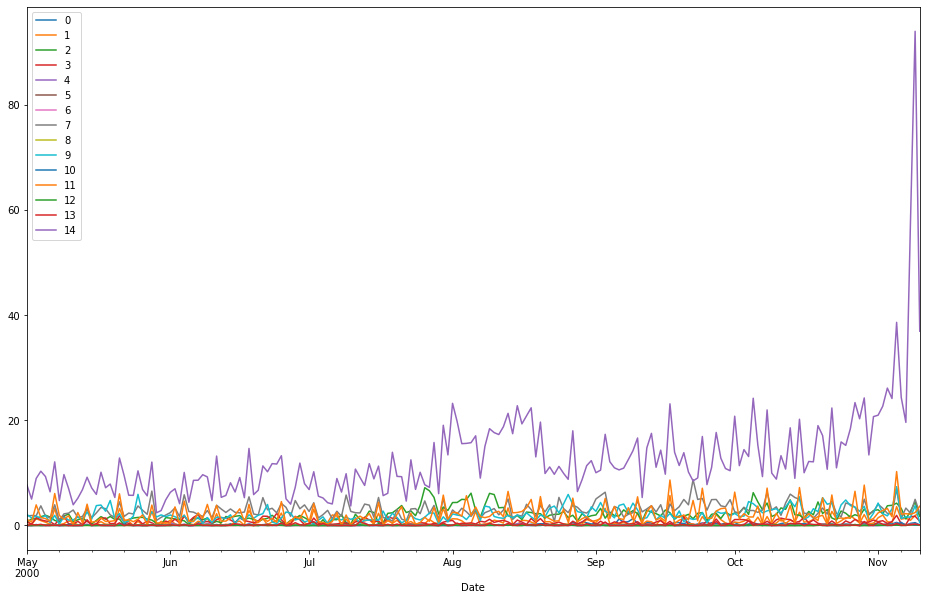

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.050067  0.716114  0.673376  0.720210  0.002974   
2000-05-02       0.504970  0.009597  0.189853  1.255632  0.258492  0.009597   
2000-05-03       0.509491  0.189399  1.285521  1.262707  1.481592  0.050849   
2000-05-04       0.511466  0.020661  0.930376  1.664188  1.078646  0.024312   
2000-05-05       0.520875  0.047317  0.623775  1.952734  0.858078  0.011935   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  0.005706  0.006057  1.813440  0.057806  2.077704  0.002974   
2000-05-02  0.009597  0.010944  1.903409  0.011755  1.453823  0.009597   
2000-05-03  0.079683  0.010849  1.863484  0.010849  1.773695  0.010849   
2000-05-04  0.014654  0.014654  3.738176  0.014654  1.407162  0.014654   
20

/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1850: RuntimeWarning: invalid value encountered in true_divide
  F /= J


56
[(55410, [250.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (56082, [250.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (59463, [0, 500.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (23473, [0, 0, 500.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (52563, [0, 0, 0, 70.35166155752667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (7490, [0, 0, 0, 70.04985159874255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (23099, [0, 0, 0, 69.37954076706815, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (43179, [0, 0, 0, 69.16715817101569, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (5321, [0, 0, 0, 65.40032802632548, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (17009, [0, 0, 0, 57.4022555469014, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (55496, [0, 0, 0, 54.953177176565376, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (41988, [0, 0, 0, 39.93705390751572, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (42369, [0, 0, 0, 2.788243606386329, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (13144, [0, 0, 0, 0.5707296419526426, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (51934, [0, 0, 0, 0, 103.788115834742

/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17645717.511643223
(15, 63104)
(4706, 16)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  0.048793  0.002974  0.056501  1.529677  0.496613  0.039733   
2000-05-02  0.009597  0.009597  0.013092  1.872350  0.273233  0.015833   
2000-05-03  0.080227  0.079683  0.010849  1.729370  0.439879  0.437203   
2000-05-04  0.045311  0.014654  0.014654  3.090257  0.560404  0.042909   
2000-05-05  0.355763  0.011935  0.011935  1.134582  0.377142  0.027446   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  2.570287  2.727405  6.296724  1.091153  0.054366  0.010189   
2000-05-02  0.748799  2.128079  5.085003  0.687072  0.061604  0.009597   
2000-05-03  5.666540  3.413389  8.341782  0.397224  0.113019  0.180483   
2000-05-04  3.430811  4.206265  8.2

<Figure size 1152x720 with 0 Axes>

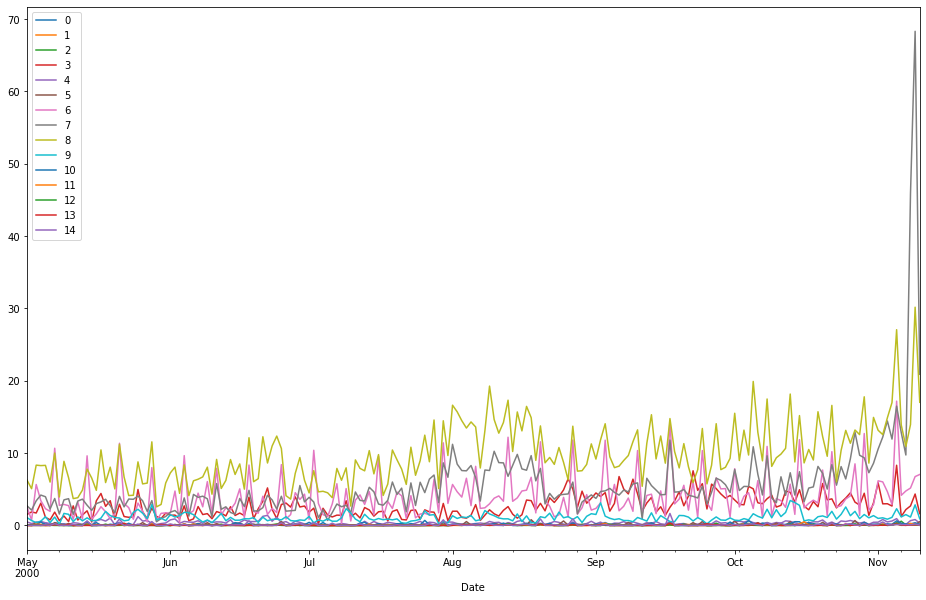

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.048793  0.002974  0.056501  1.529677  0.496613   
2000-05-02       0.504970  0.009597  0.009597  0.013092  1.872350  0.273233   
2000-05-03       0.509491  0.080227  0.079683  0.010849  1.729370  0.439879   
2000-05-04       0.511466  0.045311  0.014654  0.014654  3.090257  0.560404   
2000-05-05       0.520875  0.355763  0.011935  0.011935  1.134582  0.377142   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  0.039733  2.570287  2.727405  6.296724  1.091153  0.054366   
2000-05-02  0.015833  0.748799  2.128079  5.085003  0.687072  0.061604   
2000-05-03  0.437203  5.666540  3.413389  8.341782  0.397224  0.113019   
2000-05-04  0.042909  3.430811  4.206265  8.278402  0.599492  0.500787   
20

/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


61
[(23473, [500.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (52563, [0, 74.58002505875595, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (62611, [0, 74.31350486078426, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (23099, [0, 73.54947664941595, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (5321, [0, 69.33110029058554, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (17009, [0, 60.85231766155783, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (55496, [0, 58.2560417217044, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (33813, [0, 43.82430700626783, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (41988, [0, 42.337400642057034, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (42369, [0, 2.955826108871212, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (37602, [0, 0, 104.54306315033551, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (62624, [0, 0, 104.44884959640254, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (40761, [0, 0, 104.41947657841374, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (36049, [0, 0, 104.1676829755551, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17668124.37750442
(15, 63104)
(4706, 16)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  0.041646  1.523362  0.148039  4.490773  4.791741  3.197919   
2000-05-02  0.009597  1.332160  0.201036  3.764477  3.890899  1.429377   
2000-05-03  0.086780  1.356291  0.134951  4.979647  6.414076  6.320162   
2000-05-04  0.017835  2.650565  0.152414  6.705556  6.233709  3.857748   
2000-05-05  0.102262  0.972085  0.078648  6.585483  6.423325  2.446628   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  0.010155  0.002974  0.041551  0.342453  0.092047  0.057115   
2000-05-02  0.009597  0.009597  0.009597  0.130308  0.074303  0.068698   
2000-05-03  0.122507  0.010849  0.118903  0.198735  0.010849  0.114026   
2000-05-04  0.106880  0.014654  0.01

<Figure size 1152x720 with 0 Axes>

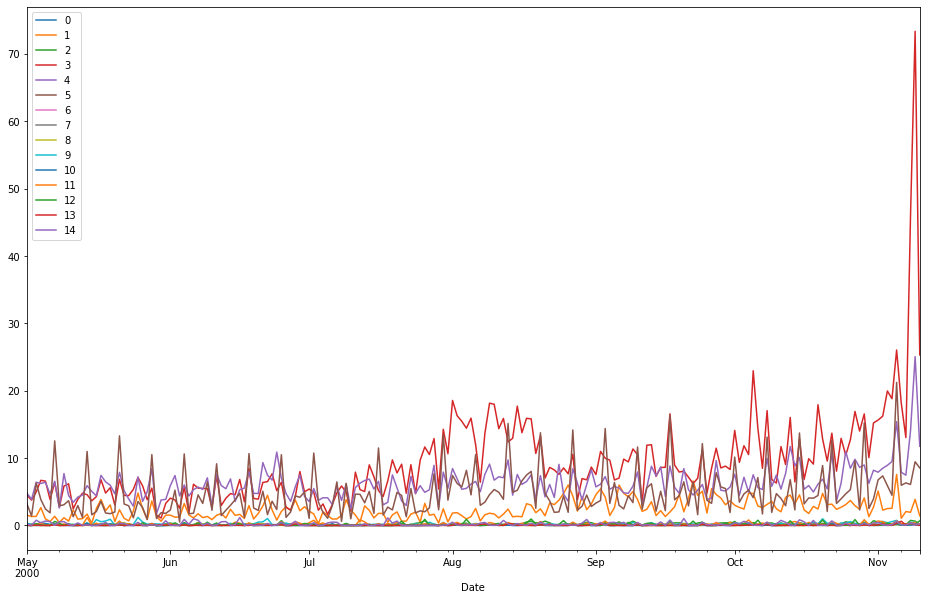

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.041646  1.523362  0.148039  4.490773  4.791741   
2000-05-02       0.504970  0.009597  1.332160  0.201036  3.764477  3.890899   
2000-05-03       0.509491  0.086780  1.356291  0.134951  4.979647  6.414076   
2000-05-04       0.511466  0.017835  2.650565  0.152414  6.705556  6.233709   
2000-05-05       0.520875  0.102262  0.972085  0.078648  6.585483  6.423325   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  3.197919  0.010155  0.002974  0.041551  0.342453  0.092047   
2000-05-02  1.429377  0.009597  0.009597  0.009597  0.130308  0.074303   
2000-05-03  6.320162  0.122507  0.010849  0.118903  0.198735  0.010849   
2000-05-04  3.857748  0.106880  0.014654  0.014654  0.408464  0.027475   
20

/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17684437.679948654
(15, 63104)
(4706, 16)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  0.023018  2.269169  0.011097  0.004710  0.152827  4.408065   
2000-05-02  0.020734  2.213931  0.060904  0.013185  0.119688  2.115520   
2000-05-03  0.380972  1.764657  0.019336  0.087585  0.395638  7.627420   
2000-05-04  0.090131  3.222534  0.029612  0.019185  0.241303  5.640250   
2000-05-05  0.123220  1.925254  0.011935  0.011935  0.250553  3.732652   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  1.201401  0.025336  6.534821  0.184841  0.010608  0.057761   
2000-05-02  0.507341  0.009597  5.484967  0.322498  0.009597  0.011745   
2000-05-03  1.957534  0.013816  8.079057  0.223105  0.138466  0.181937   
2000-05-04  1.444042  0.014654  9.8

<Figure size 1152x720 with 0 Axes>

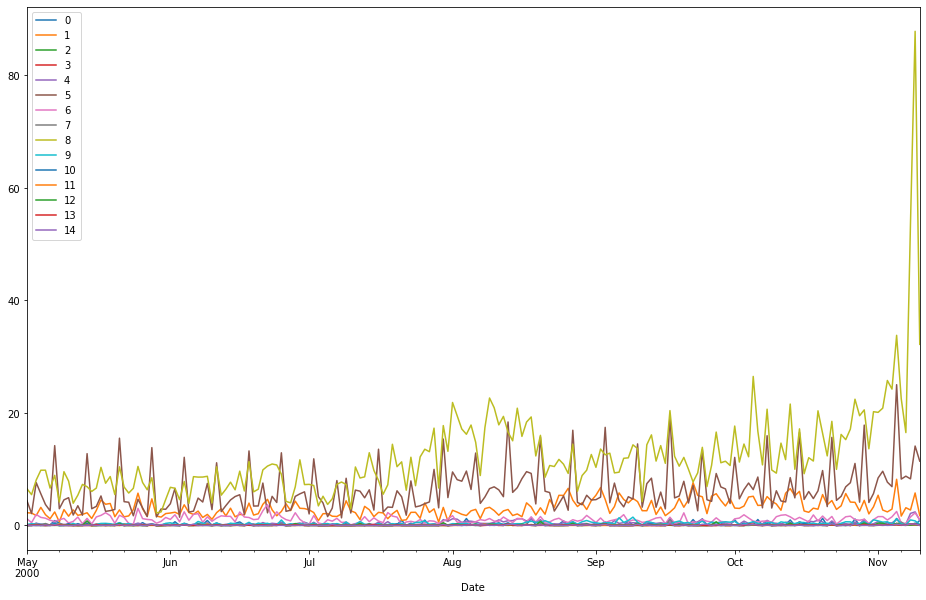

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.023018  2.269169  0.011097  0.004710  0.152827   
2000-05-02       0.504970  0.020734  2.213931  0.060904  0.013185  0.119688   
2000-05-03       0.509491  0.380972  1.764657  0.019336  0.087585  0.395638   
2000-05-04       0.511466  0.090131  3.222534  0.029612  0.019185  0.241303   
2000-05-05       0.520875  0.123220  1.925254  0.011935  0.011935  0.250553   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  4.408065  1.201401  0.025336  6.534821  0.184841  0.010608   
2000-05-02  2.115520  0.507341  0.009597  5.484967  0.322498  0.009597   
2000-05-03  7.627420  1.957534  0.013816  8.079057  0.223105  0.138466   
2000-05-04  5.640250  1.444042  0.014654  9.825363  0.185509  0.014654   
20

/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


60
[(52563, [66.9829261024773, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (62611, [66.74355500128107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (43179, [65.85514175381734, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (5321, [62.268683386859635, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (17009, [54.653592485084005, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (55496, [52.321786357587605, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (53235, [51.13474435240467, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (33813, [39.36014120913037, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (41988, [38.02469865548722, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (42369, [2.6547306958708066, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (37602, [0, 250.11269999960135, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (62624, [0, 249.88730000039862, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (32260, [0, 0, 250.27737332542415, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (62611, [0, 0, 249.72262667457582, 0, 0, 0, 0, 0, 0, 0,

/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17658957.488058176
(15, 63104)
(4706, 16)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  2.682068  0.023273  0.010366  4.217165  0.019318  0.004479   
2000-05-02  2.222137  0.051713  0.200283  1.968929  0.009597  0.009597   
2000-05-03  2.188174  0.026210  0.074758  7.849967  0.052886  0.045655   
2000-05-04  4.485398  0.016703  0.297192  5.011602  0.031748  0.070303   
2000-05-05  2.829300  0.014673  0.031796  3.464826  0.275093  0.012770   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  0.189461  4.297274  3.160382  0.018929  0.167491  0.004250   
2000-05-02  0.272173  3.668531  2.508667  0.014643  0.009597  0.009597   
2000-05-03  0.234376  4.725794  4.453114  0.247035  0.185475  0.033522   
2000-05-04  0.187407  6.458073  3.8

<Figure size 1152x720 with 0 Axes>

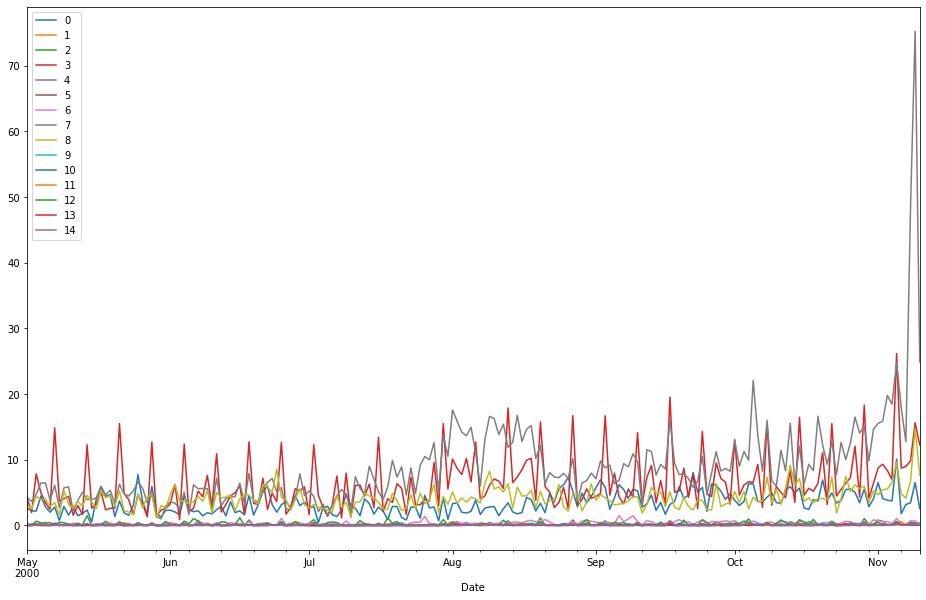

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  2.682068  0.023273  0.010366  4.217165  0.019318   
2000-05-02       0.504970  2.222137  0.051713  0.200283  1.968929  0.009597   
2000-05-03       0.509491  2.188174  0.026210  0.074758  7.849967  0.052886   
2000-05-04       0.511466  4.485398  0.016703  0.297192  5.011602  0.031748   
2000-05-05       0.520875  2.829300  0.014673  0.031796  3.464826  0.275093   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  0.004479  0.189461  4.297274  3.160382  0.018929  0.167491   
2000-05-02  0.009597  0.272173  3.668531  2.508667  0.014643  0.009597   
2000-05-03  0.045655  0.234376  4.725794  4.453114  0.247035  0.185475   
2000-05-04  0.070303  0.187407  6.458073  3.894617  0.014654  0.014654   
20

/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


44
[(61004, [64.66351308979907, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (61429, [64.66351308979907, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (13128, [64.66351308979907, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (47323, [64.66351308979907, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (53411, [64.66351308979907, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (61868, [64.66351308979907, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (30178, [64.66351308979907, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (11366, [47.35540837140654, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (52563, [0, 66.9829261024773, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (62611, [0, 66.74355500128107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (43179, [0, 65.85514175381734, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (5321, [0, 62.268683386859635, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (17009, [0, 54.653592485084005, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (55496, [0, 52.321786357587605, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17706336.784768876
(15, 63104)
(4706, 16)
                  0          1         2         3         4         5   \
Date                                                                      
2000-05-01  0.002974   7.362725  1.042211  0.186265  5.670777  0.024016   
2000-05-02  0.009597   6.387887  0.843407  0.127330  3.129715  0.013196   
2000-05-03  0.054994   7.681167  1.192406  0.343193  9.956965  0.089909   
2000-05-04  0.044090  11.129854  1.271052  0.308476  7.165770  0.014654   
2000-05-05  0.124447  10.140066  0.763383  0.368528  5.114642  0.011935   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  0.006908  0.025446  0.099284  0.024605  0.112905  0.072271   
2000-05-02  0.048533  0.078892  0.049090  0.011597  0.011048  0.011702   
2000-05-03  0.013529  0.021200  0.719689  0.072183  0.013816  0.010849   
2000-05-04  0.177437  0.2231

<Figure size 1152x720 with 0 Axes>

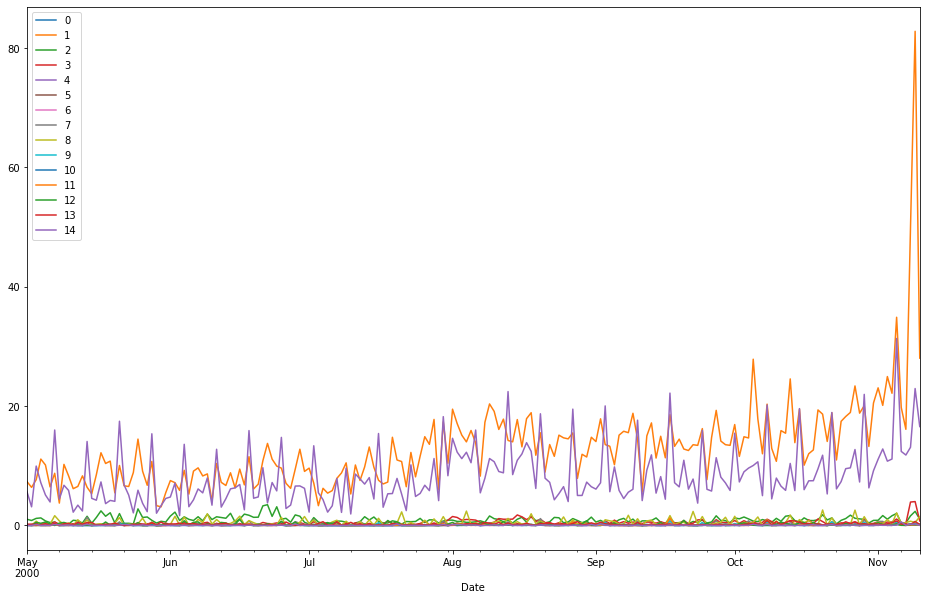

            NormLastPrice         0          1         2         3         4  \
Date                                                                           
2000-05-01       0.523810  0.002974   7.362725  1.042211  0.186265  5.670777   
2000-05-02       0.504970  0.009597   6.387887  0.843407  0.127330  3.129715   
2000-05-03       0.509491  0.054994   7.681167  1.192406  0.343193  9.956965   
2000-05-04       0.511466  0.044090  11.129854  1.271052  0.308476  7.165770   
2000-05-05       0.520875  0.124447  10.140066  0.763383  0.368528  5.114642   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  0.024016  0.006908  0.025446  0.099284  0.024605  0.112905   
2000-05-02  0.013196  0.048533  0.078892  0.049090  0.011597  0.011048   
2000-05-03  0.089909  0.013529  0.021200  0.719689  0.072183  0.013816   
2000-05-04  0.014654  0.177437  0.223170  0.122774  0.014654  0.01465

/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


60
[(61004, [57.258448253513734, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (61429, [57.258448253513734, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (13128, [57.258448253513734, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (47323, [57.258448253513734, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (34413, [57.258448253513734, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (53411, [57.258448253513734, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (61868, [57.258448253513734, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (30178, [57.258448253513734, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (11366, [41.932413971890156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (26439, [0, 500.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (30241, [0, 0, 250.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (61370, [0, 0, 250.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (23473, [0, 0, 0, 250.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (4048, [0, 0, 0, 250.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (43180, [0, 0, 0, 0, 64.63550265249856, 

/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17738508.600255325
(15, 63104)
(4706, 16)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  0.004868  0.004710  0.043753  0.061597  7.700660  1.000010   
2000-05-02  0.010944  0.009597  0.061391  0.043095  5.876487  1.730649   
2000-05-03  0.039737  0.016784  0.027715  0.121565  6.801861  2.296113   
2000-05-04  0.032432  0.014654  0.015654  0.041130  9.713720  3.187904   
2000-05-05  0.013607  0.015320  0.080404  0.131283  9.115723  2.342558   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  0.103810  5.608518  0.039283  0.035815  0.108287  0.008476   
2000-05-02  0.072039  3.038146  0.041621  0.018809  0.018391  0.014849   
2000-05-03  0.285909  9.708731  0.017527  0.447163  0.104034  0.131758   
2000-05-04  0.114796  6.985928  0.0

<Figure size 1152x720 with 0 Axes>

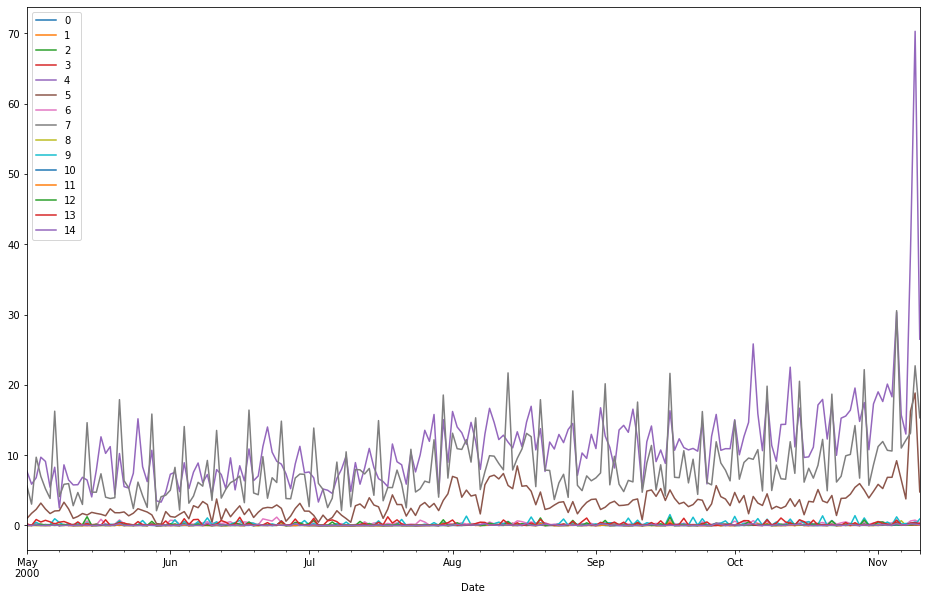

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.004868  0.004710  0.043753  0.061597  7.700660   
2000-05-02       0.504970  0.010944  0.009597  0.061391  0.043095  5.876487   
2000-05-03       0.509491  0.039737  0.016784  0.027715  0.121565  6.801861   
2000-05-04       0.511466  0.032432  0.014654  0.015654  0.041130  9.713720   
2000-05-05       0.520875  0.013607  0.015320  0.080404  0.131283  9.115723   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  1.000010  0.103810  5.608518  0.039283  0.035815  0.108287   
2000-05-02  1.730649  0.072039  3.038146  0.041621  0.018809  0.018391   
2000-05-03  2.296113  0.285909  9.708731  0.017527  0.447163  0.104034   
2000-05-04  3.187904  0.114796  6.985928  0.014654  0.098953  0.029272   
20

/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, bat

64
[(49145, [354.53764380254506, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (45899, [103.03534238515722, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (44866, [42.42701381229774, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (8361, [0, 500.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (61004, [0, 0, 51.37512803346961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (61429, [0, 0, 51.37512803346961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (13128, [0, 0, 51.37512803346961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (47323, [0, 0, 51.37512803346961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (32894, [0, 0, 51.37512803346961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (34413, [0, 0, 51.37512803346961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (53411, [0, 0, 51.37512803346961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (61868, [0, 0, 51.37512803346961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (30178, [0, 0, 51.37512803346961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (11366, [0, 0, 37.62384769877354, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),

<Figure size 1152x720 with 0 Axes>

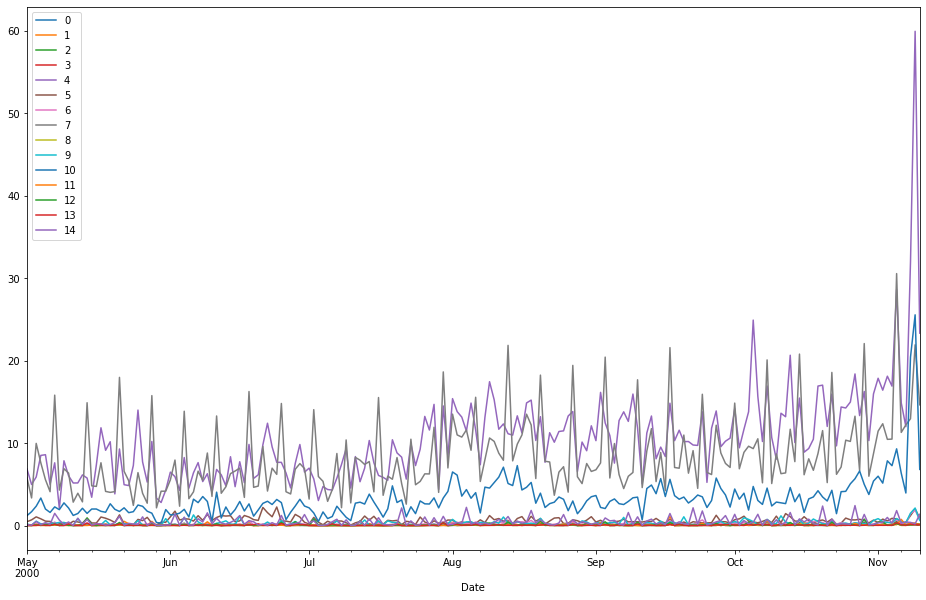

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.055092  0.017682  0.119730  0.008365  6.860909   
2000-05-02       0.504970  0.013735  0.009597  0.047720  0.014116  4.972314   
2000-05-03       0.509491  0.087969  0.016784  0.081441  0.139695  5.881896   
2000-05-04       0.511466  0.014654  0.017424  0.036022  0.060251  8.499604   
2000-05-05       0.520875  0.238370  0.071392  0.065643  0.056391  8.585437   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  0.460131  0.108079  5.804310  0.004710  0.169626  1.192579   
2000-05-02  0.682726  0.081034  3.341218  0.009597  0.042738  1.674667   
2000-05-03  1.046534  0.162155  9.955625  0.050402  0.526157  2.339843   
2000-05-04  0.808698  0.173513  7.596554  0.016791  0.196797  3.329291   
20

/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


70
[(61004, [62.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (61429, [62.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (13128, [62.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (47323, [62.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (34413, [62.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (53411, [62.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (61868, [62.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (30178, [62.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (60318, [0, 250.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (47791, [0, 250.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (60336, [0, 0, 53.75176486196471, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (43180, [0, 0, 53.745391538206285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (62611, [0, 0, 53.51940526387933, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (7490, [0, 0, 53.48092617248604, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (23099, [0, 0, 52.96916428743959, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (43179, [0, 0, 52.807016649998964, 0, 0, 0, 

<Figure size 1152x720 with 0 Axes>

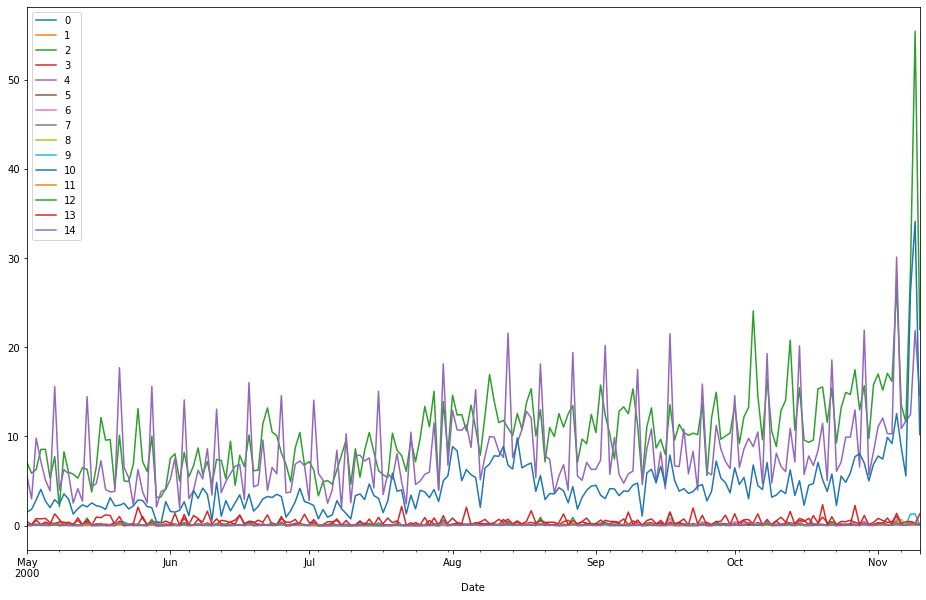

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.010319  0.072589  7.057665  0.440160  5.538212   
2000-05-02       0.504970  0.048580  0.011300  5.865807  0.098741  2.991024   
2000-05-03       0.509491  0.163822  0.073527  6.292812  0.776788  9.802552   
2000-05-04       0.511466  0.042015  0.056139  8.538316  0.746090  7.193559   
2000-05-05       0.520875  0.022981  0.040317  8.542274  0.800867  5.089433   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  0.065232  0.004914  0.016848  0.011365  0.144886  1.505017   
2000-05-02  0.027388  0.013800  0.009597  0.044889  0.014552  1.805650   
2000-05-03  0.019186  0.099673  0.052629  0.010849  0.032020  2.877537   
2000-05-04  0.020597  0.015215  0.014654  0.038159  0.045997  4.050276   
20

/home/saras/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


75
[(4048, [118.61917064810255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (61370, [118.61917064810255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (560, [118.61903097304986, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (62655, [78.80821043577339, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (57446, [65.33441729497164, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (62656, [0, 288.0405776152649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (26439, [0, 211.9594223847351, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (30241, [0, 0, 288.62763650243386, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (11366, [0, 0, 211.3723634975662, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (44843, [0, 0, 0, 55.55002680683194, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (38031, [0, 0, 0, 55.55002516273319, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (38325, [0, 0, 0, 55.54204477780678, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (32221, [0, 0, 0, 54.67465870415937, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), (34774, [0, 0, 0, 51.70652814231442, 0, 0, 0, 0, 0, 0, 0, 0

/home/saras/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass doc_topic_prior=None, topic_word_prior=None, learning_method=online, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


log likelihood score, 15 topics: -17709987.533645935
(15, 63104)
(4706, 16)
                  0         1         2         3         4         5   \
Date                                                                     
2000-05-01  0.073676  0.102588  0.008614  0.006890  0.074689  7.031126   
2000-05-02  0.009597  0.012754  0.009597  0.023164  0.036492  5.200265   
2000-05-03  0.023688  0.016784  0.046710  0.172853  0.565164  5.781842   
2000-05-04  0.017977  0.014654  0.017503  0.021388  0.038605  8.880915   
2000-05-05  0.011935  0.017012  0.016551  0.115010  0.190627  8.655801   

                  6         7         8         9         10        11  \
Date                                                                     
2000-05-01  0.474691  0.056873  5.638245  0.095579  0.068195  1.357049   
2000-05-02  0.667500  0.057828  2.986535  0.009597  0.036351  1.868043   
2000-05-03  0.894058  0.051075  9.891647  0.317912  0.109788  2.830833   
2000-05-04  0.739098  0.043702  6.9

<Figure size 1152x720 with 0 Axes>

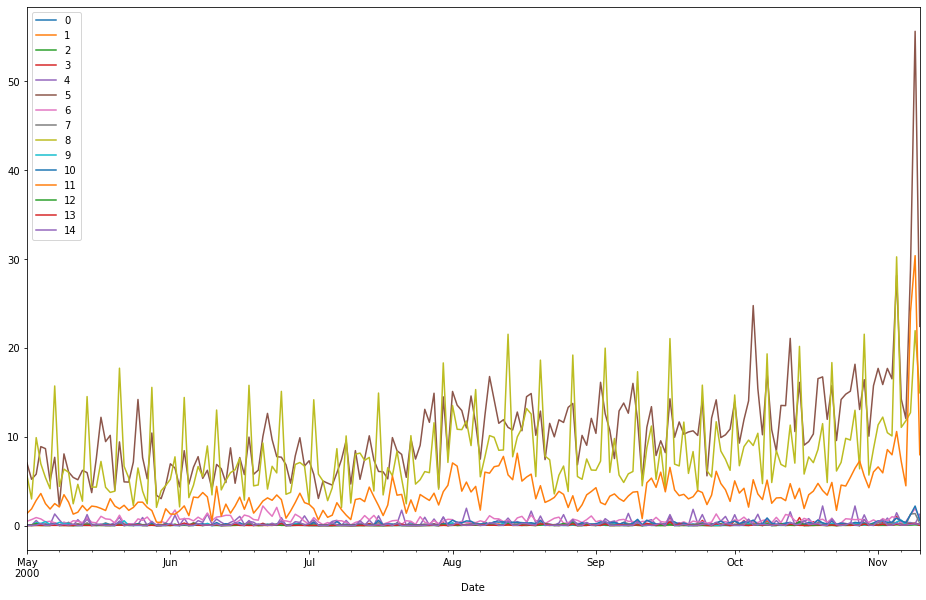

            NormLastPrice         0         1         2         3         4  \
Date                                                                          
2000-05-01       0.523810  0.073676  0.102588  0.008614  0.006890  0.074689   
2000-05-02       0.504970  0.009597  0.012754  0.009597  0.023164  0.036492   
2000-05-03       0.509491  0.023688  0.016784  0.046710  0.172853  0.565164   
2000-05-04       0.511466  0.017977  0.014654  0.017503  0.021388  0.038605   
2000-05-05       0.520875  0.011935  0.017012  0.016551  0.115010  0.190627   

                   5         6         7         8         9        10  \
Date                                                                     
2000-05-01  7.031126  0.474691  0.056873  5.638245  0.095579  0.068195   
2000-05-02  5.200265  0.667500  0.057828  2.986535  0.009597  0.036351   
2000-05-03  5.781842  0.894058  0.051075  9.891647  0.317912  0.109788   
2000-05-04  8.880915  0.739098  0.043702  6.942437  0.227271  0.213978   
20

In [12]:
# Fit LDA model to feature vector
k = 15
count = 0
max_iterations = 10

prior_topic_words = []
#prior_topic_words.append((vocabulary.index('oil'), [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
#print(prior_topic_words)

while (count < max_iterations):
    count+=1
    
    lda = PTW_LDA(n_components=15, learning_method='online', ptws=prior_topic_words)
    
    max_iterations = lda.max_iter

    lda.fit(ft_cv)

    print('log likelihood score, ' + str(k) + ' topics: ' + str(lda.score(ft_cv)))

    pyLDAvis.enable_notebook()
    p = pyLDAvis.sklearn.prepare(lda, ft_cv, cv)
    pyLDAvis.display(p)
    
    # Generate topic vs. word matrix
    # Note: the individual matrix values are pseudo counts NOT probabilities
    topic_word_matrix = pd.DataFrame((lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]), columns=vocabulary)
    print(topic_word_matrix.shape)

    # Generate document vs. topic coverage matrix
    lda_out = lda.transform(ft_cv)
    doc_topic_matrix = pd.DataFrame(lda_out)
    doc_topic_matrix['Date'] = main_df['Date']
    print(doc_topic_matrix.shape)

    # Aggregate topic coverages by each date and create topic_stream
    aggregator_topics = {i: 'sum' for i in range(k)}
    topic_stream = doc_topic_matrix.groupby(['Date']).agg(aggregator_topics)
    print(topic_stream.head())

    # Plot resulting topic streams
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.figure()
    topic_stream.plot()
    plt.show()
    
    # Prepare dem_data and topic_stream for Granger tests
    combined_topic_dem_data = pd.concat([dem_data, topic_stream], axis=1, join='inner')
    print(combined_topic_dem_data.head())
    print(pd.date_range(start='2000-05-01',end='2000-11-10').difference(combined_topic_dem_data.index))

    # Run Granger tests  against each topic and output the p values for F tests against each lag
    granger_topic_results = []

    for i in range(1,6):
            granger_topic_results.append([grangercausalitytests(combined_topic_dem_data[['NormLastPrice',j]],[i],verbose=False)[i][0]['ssr_ftest'][1] for j in range(k)])

    # Aggregate p values via mean to determine optimal lag
    granger_topic_df = pd.DataFrame(granger_topic_results)
    granger_topic_df.index = granger_topic_df.index + 1
    granger_topic_df['MeanP'] = granger_topic_df.mean(axis=1)
    granger_topic_df.sort_values(by=['MeanP'], inplace=True)
    optimal_lag = granger_topic_df.index[0]
    print(granger_topic_df)

    # With optimal lag, sort topics by p values in ascending order
    granger_topic_df.drop(['MeanP'], axis=1, inplace=True)
    topic_p_values = granger_topic_df.loc[optimal_lag].sort_values(ascending=True)

    # Check that output topics are <= 0.1... this is to give a bit of breathing room for topics boundary will be set at 0.05 for words
    top_topics = topic_p_values[topic_p_values<=0.1].index
    print(top_topics)
    
        # Choose l # of top words from top topic or max cumulative probability
    l = 25
    prob_m = 0.25

    # Choose mu value for prior pseudo count importance
    mu = 500

    topic = 0
    prior_topic_words = []
    # Sort significant topic by pseudo count in descending order
    for i in range(len(top_topics)):
        words_in_topic = topic_word_matrix.loc[top_topics[i]].sort_values(ascending=False)
        cumsum_words = words_in_topic.cumsum()
        #words_index = cumsum_words[cumsum_words <= prob_m].index ## use this only if wanting to use cumulative probabaility mass cutoff
        words_index = words_in_topic.index[:l]
    
        # Granger test on top l words for topic i
        granger_word_results = [grangercausalitytests(combined_word_dem_data[['NormLastPrice',words_index[j]]],[optimal_lag],verbose=False)[optimal_lag][0]['ssr_ftest'][1] for j in range(len(words_index))]
        granger_word_results = pd.Series(granger_word_results, index=words_index)
    
        # Pearson coefficient test on top l words for topic i
        pearson_word_results = combined_word_dem_data[words_index].corrwith(combined_word_dem_data['NormLastPrice'])
    
        # Check for only words w/ p values < 0.05
        granger_word_results = granger_word_results[granger_word_results < 0.05].sort_values(ascending=True)
        pearson_word_results = pearson_word_results[granger_word_results.index]
    
        # Count negative and positive words
        negative_words = (pearson_word_results<0).sum()
        positive_words = (pearson_word_results>0).sum()
    
        negative_bias = positive_words < negative_words*0.1
        positive_bias = negative_words < positive_words*0.1
    
        # If no words of topic met the criteria for p < 0.05 then skip to next iteration
        if negative_words == 0 and positive_words == 0:
            continue
    
        # If a topic is dominated negative OR positive then create priors for each word and assign to a single topic
        if negative_bias or positive_bias:
            if negative_bias: 
                pos_check = 0
                neg_check = 1
        
            if positive_bias: 
                pos_check = 1
                neg_check = 0
            
            priors = (1 - granger_word_results) - 0.95
        
            check = pearson_word_results
            check.loc[pearson_word_results>0] = pos_check
            check.loc[pearson_word_results<0] = neg_check
        
            priors = priors * check
            priors = priors/priors.sum()
            priors_index = priors.index
        
            for i in range(len(priors_index)):
                prior_array = [0]*k
                prior_array[topic] = priors[i]*mu
                prior_topic_words.append((vocabulary.index(priors_index[i]), prior_array))
            topic += 1
    
        # If a topic is both negative and positive w/ no dominance, split words into two topics and create priors for each topic
        else:
            transform_prior = (1 - granger_word_results) - 0.95
            temp_pos_prior = transform_prior[pearson_word_results>0]
            temp_neg_prior = transform_prior[pearson_word_results<0]
            
            pos_prior = temp_pos_prior/temp_pos_prior.sum()
            neg_prior = temp_neg_prior/temp_neg_prior.sum()
        
            pos_prior_index = pos_prior.index
            for i in range(len(pos_prior_index)):
                prior_array = [0]*k
                prior_array[topic] = pos_prior[i]*mu
                prior_topic_words.append((vocabulary.index(pos_prior_index[i]), prior_array))
        
            neg_prior_index = neg_prior.index
            for i in range(len(neg_prior_index)):
                prior_array = [0]*k
                prior_array[topic+1] = neg_prior[i]*mu
                prior_topic_words.append((vocabulary.index(neg_prior_index[i]), prior_array))
        
            topic += 2
            
    print(len(prior_topic_words))
    print(prior_topic_words)